In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gensim
import os
import collections
import pymongo
import scipy
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings('ignore')
sns.set()

# Base de datos

In [4]:
client = pymongo.MongoClient("mongodb://34.228.30.11/crime_inf_test")
db = client['crime_inf_test']
newsdb_elcomercio = db['news_elcomercio_v2']
newsdb_elcomercio_prep = db['news_elcomercio_prep']
print("La cantidad de noticias totales del periódico El Comercio es: {}".format(newsdb_elcomercio.find({}).count()))
print("La cantidad de noticias totales (preprocesadas) del periódico El Comercio es: {}".format(newsdb_elcomercio_prep.find({}).count()))

La cantidad de noticias totales del periódico El Comercio es: 1423
La cantidad de noticias totales (preprocesadas) del periódico El Comercio es: 1423


In [5]:
news_complete = newsdb_elcomercio.find({})
news = newsdb_elcomercio_prep.find({})
news_df_complete = pd.DataFrame(list(news_complete))
news_df = pd.DataFrame(list(news))

In [6]:
news_complete_text = list(news_df_complete['text'])
news_titles = list(news_df_complete['title'])
news_text = list(news_df['tokens']) #guardamos el texto preprocesado en otra lista

In [7]:
print(news_text[589]) 

[u'victoria', u'p\xe1nico', u'balacera', u'emporio', u'comercial', u'gamarra', u'tras', u'enfrentamiento', u'delincuente', u'ingres\xf3', u'restaurante', u'pepes', u'amenaz\xf3', u'arma', u'mozos', u'ayuden', u'escapar', u'polic\xedas', u'serenos', u'p\xe1nico', u'apoder\xf3', u'comerciantes', u'personas', u'van', u'comprar', u'emporio', u'comercial', u'gamarra', u'victoria', u'tarde', u'desat\xf3', u'balacera', u'enfrentamiento', u'polic\xeda', u'nacional', u'delincuentes', u'testigos', u'contaron', u'origin\xf3', u'cruce', u'jirones', u'antonio', u'bazo', u'gamarra', u'hampones', u'trat\xf3', u'asaltar', u'comerciante', u'originando', u'reacci\xf3n', u'polic\xedas', u'serenos', u'ser', u'perseguido', u'sujeto', u'hizo', u'disparos', u'aire', u'ingres\xf3', u'restaurante', u'pepes', u'amenaz\xf3', u'arma', u'mozos', u'ayuden', u'escapar', u'autoridades', u'sujeto', u'logr\xf3', u'huir', u'techos', u'local', u'pese', u'agentes', u'revisaron', u'ambientes', u'coronel', u'pnp', u'walter'

# Doc2vec model

In [5]:
model_dm = Doc2Vec.load("/home/gina_bustamante/data/pvdm/doc2vec_wikipedia_es_pvdm")

In [6]:
model_dm.docvecs.vectors_docs.shape

(1257252, 300)

In [20]:
model_dm.docvecs.most_similar("Lady Gaga")

[('Joanne (álbum)', 0.6112508773803711),
 ('Bad Romance', 0.5922989845275879),
 ('Miley Cyrus', 0.5635408163070679),
 ('Britney Spears', 0.5561521649360657),
 ('Espectáculo de medio tiempo del Super Bowl LI', 0.551128625869751),
 ('Madonna', 0.5480135083198547),
 ('Lady Gaga Live at Roseland Ballroom', 0.544819176197052),
 ('Beautiful, Dirty, Rich', 0.5444865822792053),
 ('The Fame', 0.5428696274757385),
 ('Artpop', 0.5427246689796448)]

### Inferecia de vectores 

In [11]:
elcomercio_vectors = []

In [12]:
for doc in news_text:
    vector = model_dm.infer_vector(doc)
    elcomercio_vectors.append(vector)

### Vector media

In [13]:
elcomercio_vectors = np.asarray(elcomercio_vectors)
elcomercio_vectors.shape

(1423, 300)

In [14]:
mean_vector = []
for vector in elcomercio_vectors.T:
    mean_vector.append(np.mean(vector))

In [15]:
mean_vector = np.array(mean_vector,ndmin=2)
mean_vector.shape

(1, 300)

### Distancia de cada vector al vector media

In [16]:
dist = 1 - cosine_similarity(mean_vector, elcomercio_vectors)
dist.shape

(1, 1423)

In [17]:
dist_mean = np.mean(dist)
print(dist_mean)
st_mean = np.std(dist)
print(st_mean)

0.37674674
0.06414437


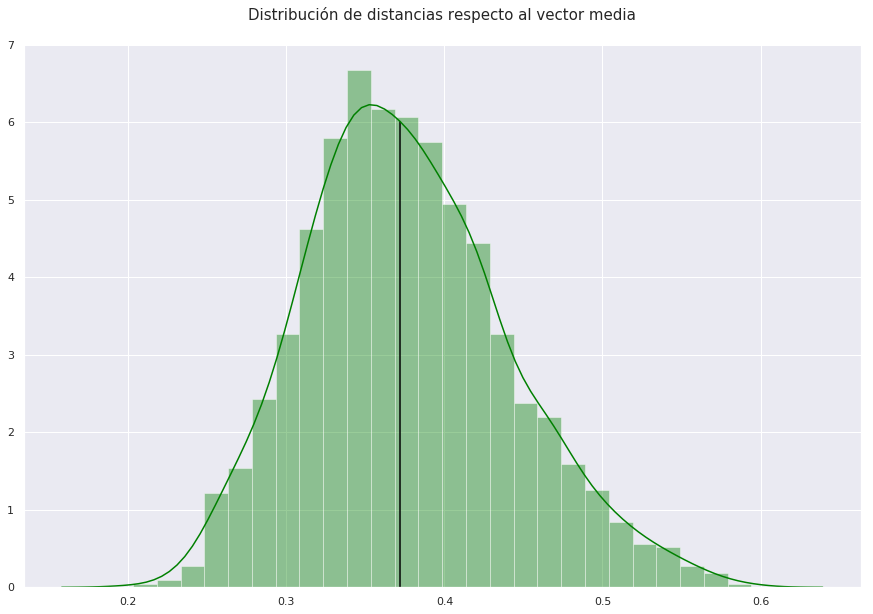

In [18]:
plt.figure(figsize=(15,10))
p = sns.distplot(dist[0], color='green')

x,y = p.get_lines()[0].get_data()
cdf = scipy.integrate.cumtrapz(y, x, initial=0)
nearest_05 = np.abs(cdf-0.5).argmin()
x_median = x[nearest_05]
y_median = y[nearest_05]
plt.vlines(x_median, 0, y_median, color='black')

plt.title('Distribución de distancias respecto al vector media\n'.decode("utf8"), fontsize=15, weight='medium')
plt.savefig("dist_doc2vec_dm_elcomercio")
plt.show()

Eliminamos los **docuemntos** que estén a mas allá de una desviación estándar del vector media

In [19]:
del_index = []
est = dist_mean + st_mean
index = 0 
for distancia in dist[0]:
    if (abs(distancia) > est):
        del_index.append(index)
    index += 1

In [20]:
print("Cantidad de documentos a eliminar: {}".format(len(del_index)))
print(del_index)

Cantidad de documentos a eliminar: 224
[7, 9, 38, 39, 40, 61, 62, 66, 68, 77, 81, 104, 108, 116, 119, 125, 127, 129, 138, 142, 153, 172, 179, 181, 198, 206, 230, 232, 249, 255, 258, 264, 265, 272, 275, 299, 321, 326, 329, 331, 335, 339, 340, 348, 353, 362, 363, 397, 415, 432, 471, 500, 503, 506, 507, 509, 516, 548, 549, 567, 578, 583, 591, 600, 602, 607, 612, 613, 616, 619, 622, 626, 628, 633, 634, 660, 669, 672, 675, 683, 684, 690, 695, 708, 716, 718, 719, 739, 748, 753, 756, 778, 783, 784, 799, 802, 812, 827, 839, 840, 841, 843, 848, 852, 857, 868, 874, 878, 881, 901, 913, 920, 925, 931, 935, 939, 941, 946, 953, 978, 984, 998, 999, 1000, 1003, 1004, 1006, 1011, 1012, 1016, 1017, 1023, 1029, 1030, 1031, 1032, 1033, 1035, 1040, 1042, 1043, 1045, 1046, 1047, 1048, 1049, 1051, 1067, 1068, 1086, 1088, 1091, 1105, 1107, 1117, 1120, 1123, 1126, 1135, 1137, 1138, 1139, 1140, 1144, 1152, 1155, 1158, 1159, 1161, 1164, 1165, 1167, 1173, 1177, 1178, 1179, 1182, 1186, 1193, 1194, 1203, 1210, 1217

In [21]:
#Ejemplo de noticia a eliminar
print(news_titles[1416])
news_complete_text[1416]

Asesinan a balazos a trabajadora del INPE en San Juan de Lurigancho


u'Selene Mabel Mart\xednez Samame fue asesinada cruelmente esta tarde al salir del penal de Lurigancho , lugar donde trabajaba como personal de salud del Instituto Nacional Penitenciario (  INPE) desde el a\xf1o 1996 . Seg\xfan testigos , Selene Mart\xednez hab\xeda salido de trabajar y se dispon\xeda a tomar un autob\xfas , en el cruce de las avenidas El Sol con la avenida Santa Rosa , en San Juan de Lurigancho , cuando un sujeto a bordo de una motocicleta le dio dos disparos en la cabeza , muriendo instant\xe1neamente . Un amigo de la v\xedctima dijo para ATV+ que ella \u201cera una persona tranquila , no ten\xeda problemas con nadie\u201d y ten\xeda una labor asistencial . En comunicado , el  INPE indic\xf3 que la muerte de Selene Mart\xednez est\xe1 en investigaci\xf3n por la Polic\xeda y el Ministerio P\xfablico . Ella ingres\xf3 al  INPE en el a\xf1o 1996 , laborando en el programa de VIH , ubicado en la cl\xednica del penal de Lurigancho . Dicha entidad lament\xf3 la muerte de l

# Eliminando los índices

In [22]:
news_df_complete.head()

,_id,date,link,newspaper_id,summary,tags,text,title
0,5b500c11b8088d1edd461dab,15.07.2018,https://elcomercio.pe/lima/policiales/villa-sa...,5b4e1d15716274ac61dd2d99,Los sujetos fueron acusados de asaltar a una p...,"[Villa El Salvador, linchamiento, linchar]",Dos hombres acusados de robar a una profesora ...,Villa El Salvador: vecinos casi linchan a pres...
1,5b500c12b8088d1edd461dac,15.07.2018,https://elcomercio.pe/lima/policiales/surquill...,5b4e1d15716274ac61dd2d99,La vivienda estaba hecha con material de 'trip...,"[Surquillo, Incendio]",El propietario de un inmueble salvó de morir e...,Surquillo: hombre salva de morir en incendio d...
2,5b500c14b8088d1edd461dae,14.07.2018,https://elcomercio.pe/lima/policiales/villa-sa...,5b4e1d15716274ac61dd2d99,El establecimiento no contaba con licencia de ...,"[Policía Nacional del Perú, Villa El Salvador,...",Personal de Fiscalización de la Municipalidad ...,Clausuran bar ‘El Encanto’ de Villa el Salvado...
3,5b500c15b8088d1edd461daf,14.07.2018,https://elcomercio.pe/lima/policiales/feminici...,5b4e1d15716274ac61dd2d99,"Juan Isaac Palomino Fernández, 41, dejó una ca...","[Feminicidio, San Miguel]","El último miércoles , una mujer de 22 años fue...",Feminicidio en San Miguel: buscan a confeso as...
4,5b500c16b8088d1edd461db0,14.07.2018,https://elcomercio.pe/lima/policiales/violacio...,5b4e1d15716274ac61dd2d99,Robert Martínez Pinto es acusado de dopar y vi...,"[Violación sexual, Independencia]",Nadie se explica cómo Robert Martínez Pinto nu...,Violaciones en Independencia: denuncian que fi...


In [23]:
print("Cantidad original de noticias: {}".format(len(news_df_complete)))
print("Cantidad de noticias a eliminar: {}".format(len(del_index)))
print("Porcentaje: {}".format((len(del_index)/float(len(news_df_complete)))*100))

Cantidad original de noticias: 1423
Cantidad de noticias a eliminar: 224
Porcentaje: 15.7413914266


In [24]:
news_df_filtered = news_df_complete.drop(del_index)

In [25]:
print("Cantidad de noticias después de filtrar: {}".format(len(news_df_filtered)))

Cantidad de noticias después de filtrar: 1199


In [26]:
newsdb_elcomercio_filtered = db['news_elcomercio_filtered_dm']

In [27]:
#Guardamos las noticias filtradas en una nueva colleción
for index, row in news_df_filtered.iterrows():
    row_dict = row.to_dict()
    newsdb_elcomercio_filtered.insert_one(row_dict)